Shor's Order factoring algorithm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

[Text(0.5, 0, 'Number of applications of U'),
 Text(0, 0.5, 'End state of register'),
 Text(0.5, 1.0, 'Effect of Successive Applications of U')]

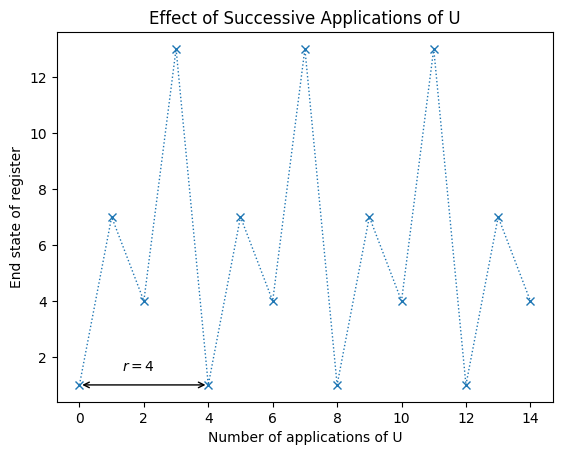

In [4]:
N = 15
a = 7

# Calculate the plotting data
xvals = np.arange(N)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')
ax.set(xlabel='Number of applications of U', ylabel='End state of register',
       title="Effect of Successive Applications of U")

In [5]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [6]:
# Specify variables
n_count = 4  # number of counting qubits
a = 7

In [9]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

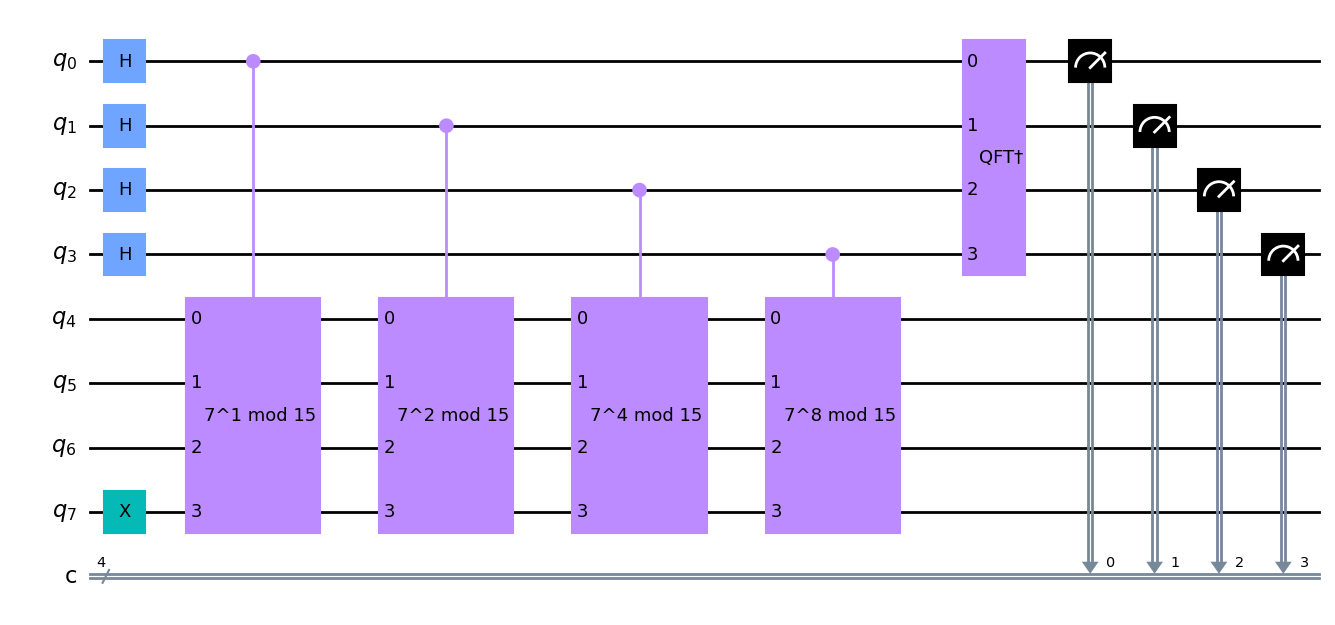

In [12]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
#qc.draw(fold=-1)  # -1 means 'do not fold' 
qc.draw("mpl")

/Users/choi/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/choi/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


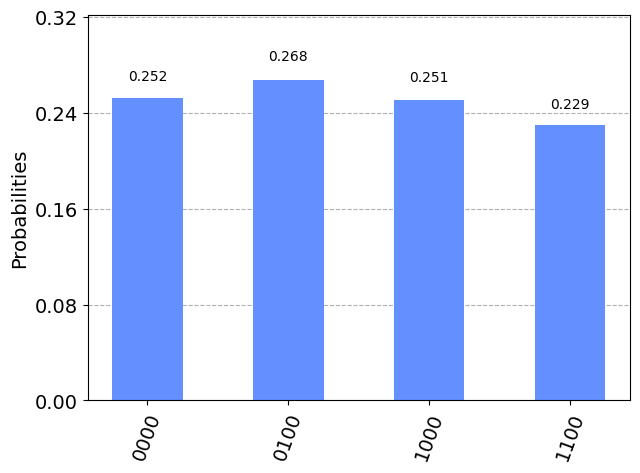

In [13]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [14]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

        Register Output         Phase
0  1100(bin) =  12(dec)  12/16 = 0.75
1  0100(bin) =   4(dec)   4/16 = 0.25
2  0000(bin) =   0(dec)   0/16 = 0.00
3  1000(bin) =   8(dec)   8/16 = 0.50


In [15]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [16]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [17]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.25      1/4            4
2   0.00      0/1            1
3   0.50      1/2            2


In [18]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [19]:
a2jmodN(7, 2049, 15)

1

In [20]:
N = 15

In [21]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


In [22]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [23]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [24]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 11000000
Corresponding Phase: 0.750000


/Users/choi/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/choi/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fraction(3, 4)

In [25]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [26]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


In [27]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***
